# Data Analysis Methods
## \[5ARB0\] Data Acquisition and Analysis - Technical Assignment

In [1]:
# this cell imports the libraries or packages that you can use during this assignment
# you are not allowed to import additional libraries or packages
from helpers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

> **Important**
>
> Do not import any other packages or libraries than the ones already provided to you. You can only use the imported packages _after_ they have been imported.
>
> Write your code between the `BEGIN_TODO` and `END_TODO` markers. Do not change these markers.
>
> Restart your notebook and run all cells before submission.

## Introduction
In this assignment you will learn about different data analysis methods for creating a fall detector. 

This assignment is split into 4 parts. Part 1 will focus on principal component analysis and part 2 will introduce independent component analysis. Part 3 will guide you through implementing your own K-means algorithm. Finally, part 4 will introduce you to the Gaussian mixture model, which you will train using the expectation-maximization algorithm. In the next assignment, you will work on using these methods for creating a fall detector.


### Learning goals
After this assignment you can
- implement the PCA algorithm;
- determine a suitable number of PCA components;
- use PCA for image compression;
- use the ICA algorithm;
- explain differences between PCA and ICA;
- implement the K-means algorithm;
- explain issues and shortcoming of the K-means algorithm;
- implement the Gaussian mixture model for clustering;
- explain how the Gaussian mixture model differs from the K-means algorithm;
- apply both algorithms on a real data set;

## Part 1: Principal component analysis

Recorded data is often high-dimensional, leading to a large computational burden and limiting real-time data processing. Quite often we would therefore like to compress the data, such that it uses less memory. The creation of .zip-files on your computer is an example of data compression. In this part we will look at one method that achieves data compression, namely Principal component analysis (PCA). PCA is a useful technique for analyzing high-dimensional data, and compressing this data for storage or processing purposes. PCA aims to fit a orthogonal coordinate system to a dataset that best captures the variance or spread of the data. This approach is very closely related to the eigendecomposition of a matrix.

PCA aims to find the orthogonal directions of most variance of the dataset. Therefore it first computes the covariance matrix of the dataset, which can be estimated as
$$\Sigma = \mathrm{Cov}[{\bf{x}}] \approx \frac{1}{N-1} \sum_{n=1}^N ({\bf{x}}_n - \mathrm{E}[{\bf{x}}])({\bf{x}}_n - \mathrm{E}[{\bf{x}}])^\top,$$
where ${\bf{x}}_n$ is the $n$-th data sample and where $\mathrm{E}[{\bf{x}}]$ represents the expected value, or mean, which can be estimated as
$$\mathrm{E}[{\bf{x}}] \approx \frac{1}{N} \sum_{n=1}^N {\bf{x}}_n.$$
The covariance matrix captures the variances of the individual elements/features in ${\bf{x}}_n$ and the covariances between elements/features. 

Based on the obtained covariance matrix, you will perform an eigendecomposition. An eigenvalue decomposition finds a set of eigenvectors and corresponding eigenvalues. An eigenvector ${\bf{v}}$ and corresponding eigenvalue ${\lambda}$ of some square matrix $A$ satisfy the equation
$$A {\bf{v}} = \lambda {\bf{v}}.$$
In matrix notation, this can be written as
$$A Q = Q\Lambda,$$
where $Q$ is a orthonormal matrix where each column represents an eigenvector. Orthonormal refers to the individual eigenvectors being of unit length, and perpendicular to eachother. This matrix satisfies the useful properties $QQ^\top = Q^\top Q = I$ and $Q^\top = Q^{-1}$. $\Lambda$ is a diagonal matrix, whose diagonal contains the eigenvalues of $A$. The matrix $A$ can therefore be decomposed as 
$$A = Q\Lambda Q^\top$$

---
---
### Exercise 1.1: Compute eigenvalues and eigenvectors


Write a function `compute_eigen(X)` which computes the eigenvalues and eigenvectors of the covariance matrix of some dataset `X`. The dataset is a matrix of shape ($N\times M$), where $N$ denotes the number of data samples and $M$ the dimensionality of the features. The function should return a vector of length $M$ containing the eigenvalues and a matrix of shape ($M\times M$) containing the corresponding eigenvectors.

In [2]:
#// BEGIN_TODO [5ARB0_Analysis_1_1a] Compute eigenvalues and eigenvectors


def compute_eigen(X):
    # Calculate the covariance matrix of the dataset
    covariance_matrix = np.cov(X, rowvar=False) # rowvar=False each column corresponds to a variable 
    
    # Compute the eigenvalues and eigenvectors of the covariance matrix, using eigh b/c it's always symmetric 
    eigvals, eigvecs = np.linalg.eigh(covariance_matrix)
    
    return eigvals, eigvecs


#// END_TODO [5ARB0_Analysis_1_1a]

(array([ 0.99412675, 10.94683841]),
 array([[-0.50418999, -0.86359276],
        [-0.86359276,  0.50418999]]))

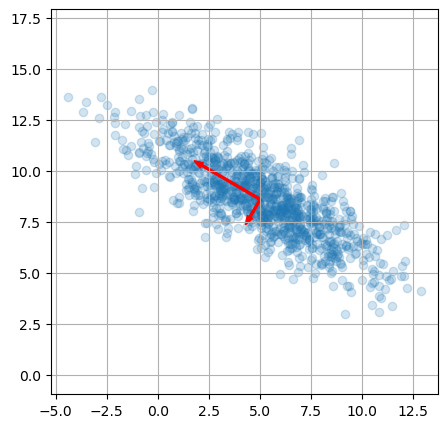

In [3]:
# generate data
X = ex11_generate_data()

# compute eigenvalues and eigenvectors
eigvals, eigvecs = compute_eigen(X)

# plot data
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plot_eigen(np.mean(X, axis=0), eigvals, eigvecs, plt.gca(), width=0.1, color="r")
plt.axis("equal")
plt.grid()

# print eigenvalues and eigenvectors
eigvals, eigvecs

Have a look at the computed eigenvalues, eigenvectors and the visualization and answer the questions below:
- In what direction does the first eigenvector point?
- How can the eigenvalue be interpreted?

`#// BEGIN_TODO [5ARB0_Analysis_1_1b] Interpretation of eigenvalues and eigenvectors`

<div class='alert alert-warning' role='alert'>
    1. It points to right - down, in parallel to the slope of the scattered data points.<br/>
    2. Eigenvalue (absolute value) shows how much of the total variance of datapoints is captured by the corresponding eigenvector. The bigger eigenvalue means more datapoints' variance is represented by that eigenvector.
</div>

`#// END_TODO [5ARB0_Analysis_1_1b]`

### End of exercise 1.1
---
---

With the computed eigendecomposition, the original dataset can be transformed such that its new mean coincides with the origin (0,0) and that the new eigenvectors specify Euclidean standard basis vectors (i.e. the new covariance matrix is diagonal). The first step can be obtained by subtracting the mean from the dataset. The origin-centered dataset $\tilde{X}$ now is centered in the origin and therefore the covariance matrix can be estimated as 
$$ \tilde{\Sigma} = \mathrm{Cov}[\tilde{\bf{x}}] \approx \frac{1}{N-1} \tilde{X}^\top \tilde{X}\qquad\qquad \text{if }\mathrm{E}[\tilde{{\bf{x}}}] = {\bf{0}}$$
with the corresponding eigendecomposition $\tilde{\Sigma} = \tilde{Q} \tilde{\Lambda} \tilde{Q}^\top$.

If we multiply $\tilde{X}$ with $\tilde{Q}$ to get the transformed dataset $Y=\tilde{X}\tilde{Q}$, we observe that the new covariance matrix becomes
$$\mathrm{Cov}[{\bf{y}}] \approx \frac{1}{N-1} Y^\top Y = \frac{1}{N-1}\tilde{Q}^\top \tilde{X}^\top \tilde{X} \tilde{Q} = \tilde{Q}^\top\tilde{\Sigma}\tilde{Q} = \tilde{Q}^\top\tilde{Q} \tilde{\Lambda} \tilde{Q}^\top\tilde{Q} = \tilde{\Lambda},$$
which is diagonal.



---
---
### Exercise 1.2: Data transformation

Write a function `transform_PCA(X, mean, eigvecs)` which translates some dataset `X` to be centered in the origin, and rotates it, such that its new covariance matrix is diagonal. $X$ is of shape ($N\times M$), where $N$ denotes the number of data samples and $M$ the dimensionality of the features. The function should return the transformed dataset of shape ($N\times M$). Also create the function `inversetransform_PCA(X, mean, eigvecs)` which performs the inverse transform.

In [4]:
#// BEGIN_TODO [5ARB0_Analysis_1_2a] Transform data to PCA space

def transform_PCA(X, mean, eigvecs):
    # Center the dataset at the origin
    centered_X = X - mean
    
    # Rotate the centered dataset using the eigenvectors (dot product)
    transformed_X = np.dot(centered_X, eigvecs)
    
    return transformed_X

#// END_TODO [5ARB0_Analysis_1_2a]

In [5]:
#// BEGIN_TODO [5ARB0_Analysis_1_2b] Transform data back from PCA space

def inversetransform_PCA(X, mean, eigvecs):
    # Inverse rotation: Multiply by the transpose of eigenvectors
    inverse_transformed_X = np.dot(X, eigvecs.T)
    
    # Add the mean back to de-center the data
    original_X = inverse_transformed_X + mean
    
    return original_X

#// END_TODO [5ARB0_Analysis_1_2b]

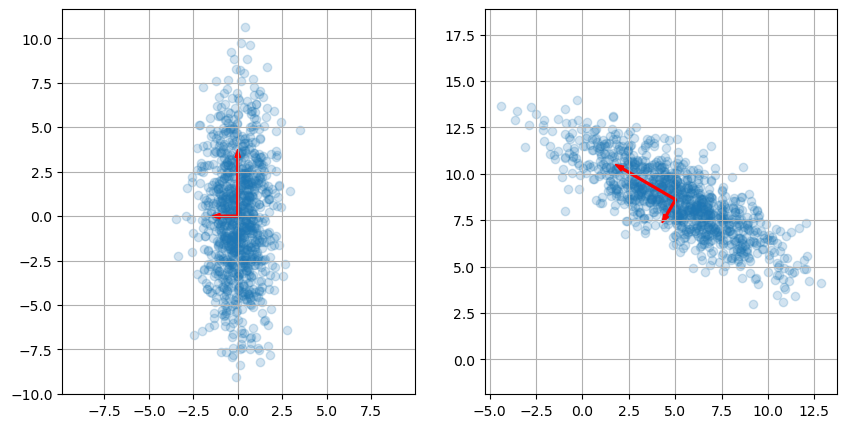

In [6]:
# transform data
m = np.mean(X, axis=0)
eigvals, eigvecs = compute_eigen(X)
Y = transform_PCA(X, m, eigvecs)
Z = inversetransform_PCA(Y, m, eigvecs)

# plot transformed data
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].scatter(Y[:,0], Y[:,1], alpha=0.2)
eigvalsY, eigvecsY = compute_eigen(Y)
plot_eigen(np.mean(Y, axis=0), eigvalsY, eigvecsY, ax[0], width=0.1, color="r")
ax[1].scatter(Z[:,0], Z[:,1], alpha=0.2)
eigvalsZ, eigvecsZ = compute_eigen(Z)
plot_eigen(np.mean(Z, axis=0), eigvalsZ, eigvecsZ, ax[1], width=0.1, color="r")
ax[0].axis("equal"), ax[1].axis("equal")
ax[0].grid(), ax[1].grid();

### End of exercise 1.2
---
---

So far PCA has only been discussed for a toy example. Let's now apply it to high-dimensional data. We will load a dataset containing 400 images of faces. These grayscale images are of size (64 $\times$ 64) and therefore contain 4096 pixels. In order to process the images, they have been flattened into vectors, which are appended to create a matrix containing 400 images. Below we have plotted the first 100 images:

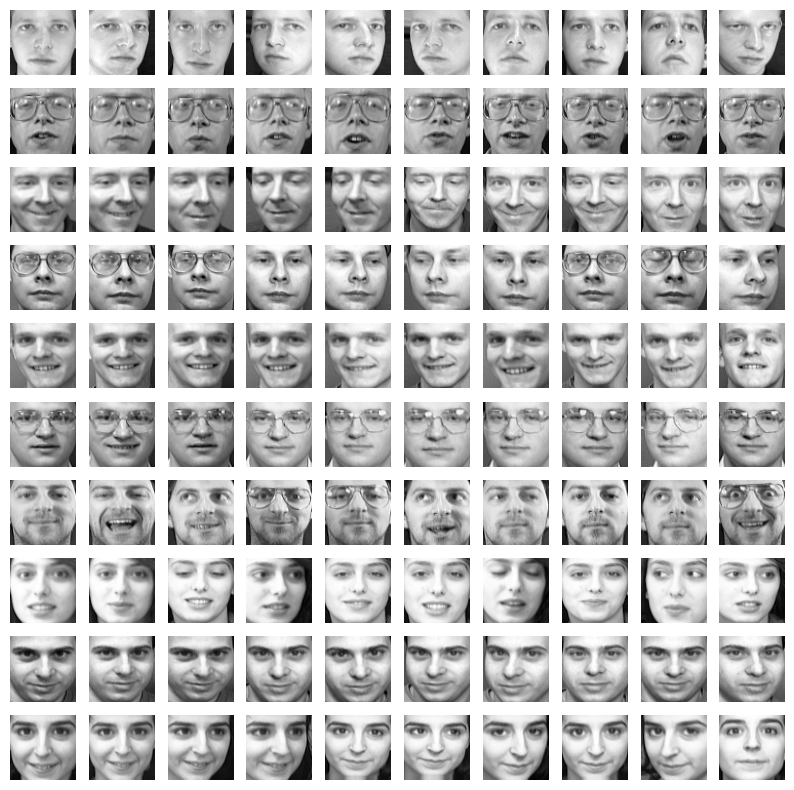

In [7]:
X = ex13_generate_data()
plot_faces(X)

---
---
### Exercise 1.3: Principal components analysis
Compute the eigenvalues and vectors of the faces dataset. Plot the first 350 eigenvalues with both a normal as log-scaling on the y-axis.

> Note: Since the dataset only contains 400 images, the covariance matrix of size (4096 $\times$ 4096) is not positive definite (although it should be in theory). Therefore the eigenvalues > 400 are basically useless, however, they are still computed as imaginary quantities. You can plot the real or absolute values of the eigenvalues.

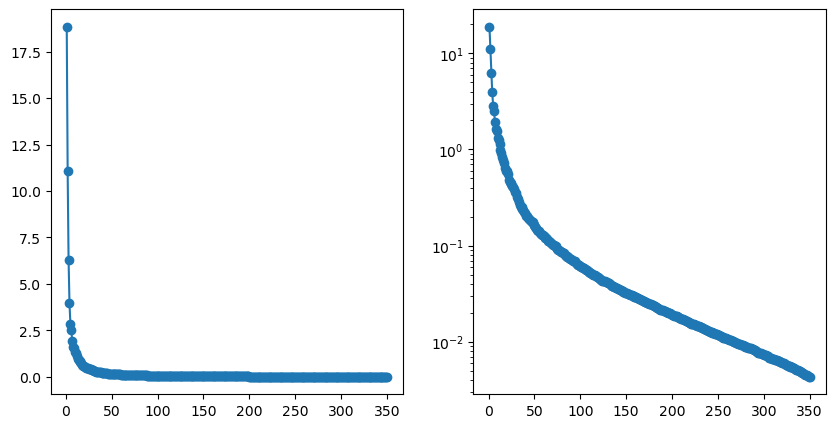

In [8]:
#// BEGIN_TODO [5ARB0_Analysis_1_3a] Plot eigenvalues

# Compute eigenvalues and eigenvectors
eigenvals, eigenvecs = compute_eigen(X)

# Sort all eigenvalues in descending order 
sorted_eigenvals = np.sort(eigenvals)[::-1]

# Plot the first 350 eigenvalues 
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

# Normal Scale 
ax[0].plot(range(1, 351), sorted_eigenvals[:350], marker='o', linestyle='-')

# Logarithmic scale
ax[1].semilogy(range(1, 351), sorted_eigenvals[:350], marker='o', linestyle='-')

# log-scale on the y-axis
plt.yscale('log')
plt.show()

#// END_TODO [5ARB0_Analysis_1_3a]

Based on the created plots, what do you observe? How could this be useful for data compression?

`#// BEGIN_TODO [5ARB0_Analysis_1_3b] What do you observe?`

<div class='alert alert-warning' role='alert'>
As mentioned before, eigeonvalues represent how much of the total variance of datapoints is captured by the corresponding eigenvector. In other words, the bigger eigeonvalue means more datapoints' variance is represented by that eigenvector. Therefore, we should focus on bigger eigeonvalues (i.e. first 50 eigeonvalues) and discard the smaller ones for data compression, which ensures that more data is captured. 
</div>

`#// END_TODO [5ARB0_Analysis_1_3b]`

### End of exercise 1.3
---
---

Now we will use PCA for data compression. Instead of performing the transform to the PCA space with the entire eigenvector matrix with shape (4096 $\times$ 4096), we only use the $K$ eigenvectors corresponding with the $K$ largest eigenvalues. 

---
---
### Exercise 1.4: Data compression
Compress the faces dataset using PCA in a matrix of shape (400 $\times$ $K$) and then decompress the data and plot the faces using the `plot_faces()` function. 

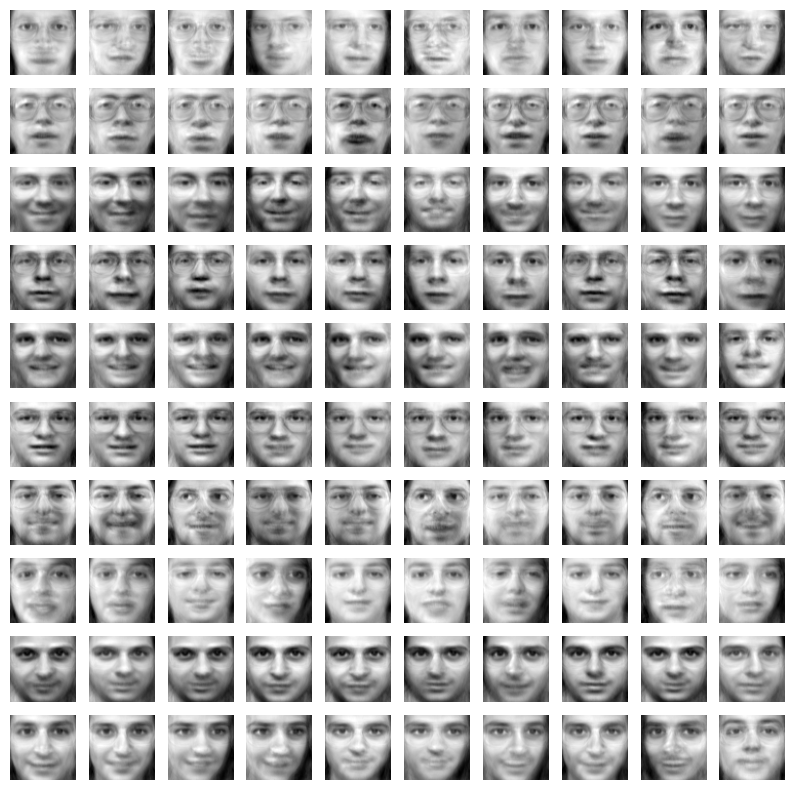

In [9]:
#// BEGIN_TODO [5ARB0_Analysis_1_4a] Data compression

# Number of components (K) for compression
K = 30;

# Compute eigenvalues and eigenvectors
eigenvals, eigenvecs = compute_eigen(X)

# Sort eigenvalues and eigenvectors in descending order 
sorted_indices = np.argsort(eigenvals)[::-1] # np.sort() returns the sorted array whereas np.argsort() returns an array of the corresponding indices.
sorted_eigenvals = eigenvals[sorted_indices]
sorted_eigenvecs = eigenvecs[:, sorted_indices]

# Use the 𝐾 eigenvectors corresponding with the 𝐾 largest eigenvalues 
large_K_eigenvecs = sorted_eigenvecs[:, 0:K]

# Compress original data onto the reduced eigenvectors
m = np.mean(X, axis=0)
compressed_X = transform_PCA(X, m, large_K_eigenvecs)
# Reconstruct the original dataset
reconstructed_X = inversetransform_PCA(compressed_X, m, large_K_eigenvecs)

#Plot the decompressed faces using the plot_faces function
plot_faces(reconstructed_X)



#// END_TODO [5ARB0_Analysis_1_4a]

Analyze the results. What do you observe if you change $K$?

`#// BEGIN_TODO [5ARB0_Analysis_1_4b] What do you observe?`

<div class='alert alert-warning' role='alert'>
K's value determines how many of eigenvectors are used for compression. The smaller K is, the more eigenvectors are discarded, and as a result, the worse the quality of reconstructed photos is. 
</div>

`#// END_TODO [5ARB0_Analysis_1_4b]`

### End of exercise 1.4
---
---

## Part 2: Independent component analysis

Another approach of finding the most important components in a dataset is independent component analysis (ICA). Below you will use it to analyze a new data set.

---
---
### Exercise 2.1: Limitations PCA
Have a look at the dataset below. Would PCA be a good approach for finding the components of highest variance? Please motivate your answer.

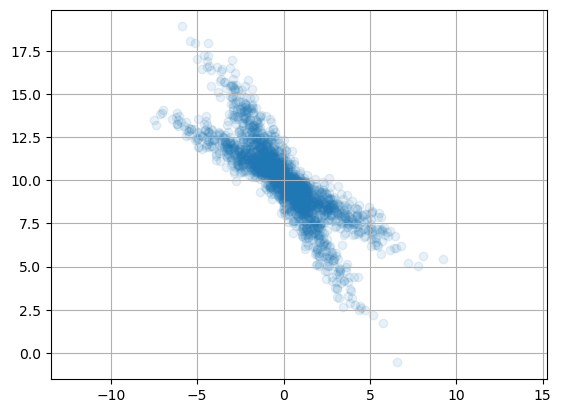

In [10]:
X = ex21_generate_data()
plt.scatter(X[:,0], X[:,1], alpha=0.1)
plt.grid(True)
plt.axis("equal");

`#// BEGIN_TODO [5ARB0_Analysis_2_1] Limitations PCA`

<div class='alert alert-warning' role='alert'>
PCA is not a good approach here because the principle components (eigenvectors) in PCA are orthogonal. However, the datapoints we see here, clearly, cannot be represented by orthogonal vectors.

</div>

`#// END_TODO [5ARB0_Analysis_2_1]`

### End of exercise 2.1
---
---

In [11]:
from sklearn.decomposition import PCA, FastICA

> Note: From this moment onwards you can use the `PCA` and `FastICA` functions from `sklearn`.

---
---
### Exercise 2.2: PCA versus ICA
Use the `PCA` and `FastICA` functions from `sklearn` to create the objects `pca_object` and `ica_object`, each with two components. Fit these objects to the dataset and transform the dataset. Save the transformed dataset into the variables `data_transformed_pca` and `data_transformed_ica`.

In [12]:
#// BEGIN_TODO [5ARB0_Analysis_2_2a] PCA and ICA
#max_iter=200
# Create Objects
pca_object = PCA(n_components = 2)
ica_object = FastICA(n_components = 2)

# Fit objects to dataset and transform it
data_transformed_pca = pca_object.fit_transform(X)  # fit_transform converts a collection of text documents into a numerical matrix
data_transformed_ica = ica_object.fit_transform(X)

#// END_TODO [5ARB0_Analysis_2_2a]

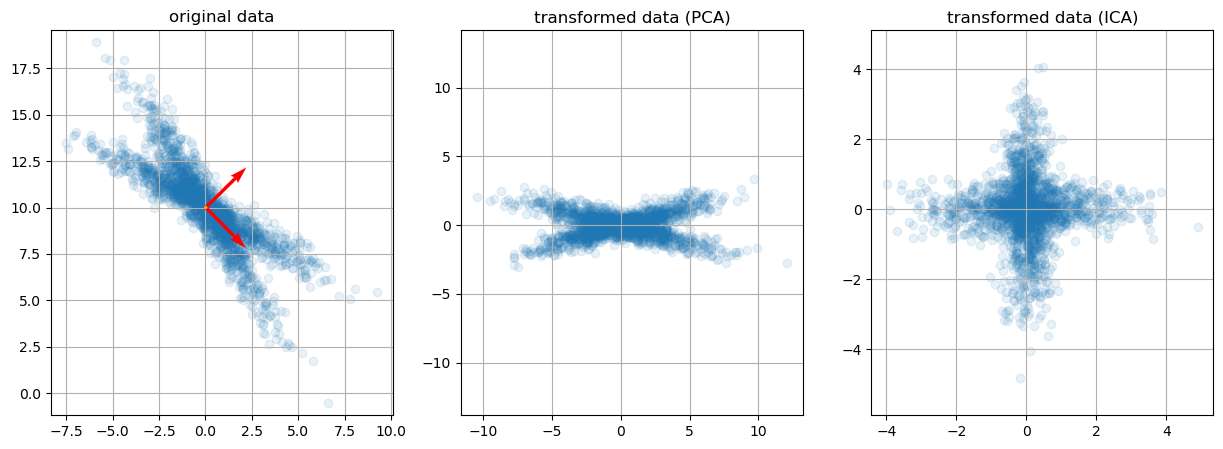

In [13]:
_, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].scatter(X[:,0], X[:,1], alpha=0.1)
ax[1].scatter(data_transformed_pca[:,0], data_transformed_pca[:,1], alpha=0.1)
ax[2].scatter(data_transformed_ica[:,0], data_transformed_ica[:,1], alpha=0.1)
plot_pca(ax[0], pca_object, np.mean(X, axis=0))
plot_ica(ax[0], ica_object, np.mean(X, axis=0))
ax[0].grid(True), ax[1].grid(True), ax[2].grid(True)
ax[0].axis('equal'), ax[1].axis('equal'), ax[2].axis('equal')
ax[0].set_title("original data"), ax[1].set_title("transformed data (PCA)"), ax[2].set_title("transformed data (ICA)");

Run your code a couple of times. What do you observe? Which method works best for this data set?

`#// BEGIN_TODO [5ARB0_Analysis_2_2b] PCA versus ICA`

<div class='alert alert-warning' role='alert'>
    ICA preserves the independece of the datapoints, whereas PCA captures as much variance of the dataset as possible. <br/>
    Since our orginal data is indepdent clusters of datapoint, ICA is a better method. 
</div>

`#// END_TODO [5ARB0_Analysis_2_2b]`

### End of exercise 2.2
---
---

## Part 3: K-means algorithm
In this part we will discuss unsupervised machine learning problems and describe how the K-means algorithm can be used to solve these.

Unsupervised machine learning problems are problems in which we try to determine some particular structure within a data set. On the contrary, supervised machine learning problems require us to model some kind of input-output mapping. Unsupervised machine learning problems do not have a specified output which we would like to model. Instead we are interesting in making sense of the data in grouping this data, without knowing beforehand which and how many groups exist.

The K-means algorithm can group $N$ data samples of dimension $D$ into $K$ groups or clusters. These clusters can each be characterized by their mean vector: the expected or average value of the points which are assigned to the cluster. The mean vector denoting the center of the $k^{th}$ cluster can be represented as the column vector ${\bf{\mu}}^{(k)} = [\mu_1^{(k)},\ \mu_2^{(k)},\ \ldots, \mu_D^{(k)}]^\top$ and the $n^{th}$ data sample can be represented by the column vector ${\bf{x}}^{(n)} = [x_1^{(n)},\ x_2^{(n)},\ \ldots, x_D^{(n)}]^\top$, where the superscript denotes the sample index.

The K-means algorithm tries to minimize the (within-cluster) Euclidean squared distance
$$J({\bf{X}}, {\bf{\mu}}) = \frac{1}{N}\sum_{n=1}^N \sum_{k=1}^K \rho_k^{(n)} \| {\bf{x}}^{(n)} - {\bf{\mu}}^{(k)}\|^2$$
Here $\rho_k^{(n)}$ is a so-called indicator function that is defined as 
$$ \rho_k^{(n)} = \begin{cases} 1 & \text{if sample }{\bf{x}}^{(n)}\text{ is assigned to cluster }k \\ 0 & \text{otherwise}\end{cases}$$
This indicator function equals $1$ when the corresponding data point is assigned to the corresponding cluster and $0$ otherwise. The cost function therefore represents the average squared distance with respect to the cluster that a point is assigned to.

The algorithm is specified as follows:

1. Initialize means ${\bf{\mu}}$.
2. Assign data points to closest cluster mean (i.e. update $\rho_k^{(n)}$).
3. Calculate new cluster means as the average values of the points that are assigned to it (i.e. update ${\bf{\mu}}$).
4. Calculate cost function $J({\bf{X}}, {\bf{\mu}})$.
5. If not converged, go back to 2 and repeat.

Here we will describe the algorithm in words. First the centers of the clusters are initialized. This can be done arbitrarily, but often the centers are set to random (but distinct) samples of the data set.
Once the means are set, we assign each data sample to the cluster that is closest to it. In order to do so, we calculate the Euclidean squared distance between a point and all the clusters and find the cluster that is closest to it. We repeat this for all points and we therefore completely specify $\rho_k^{(n)}$. Once all points have been assigned to a cluster, we look up all points corresponding to a certain cluster and we average these to calculate the new cluster center. We update all cluster means. Then we evaluate the current fit of the clusters on the data by evaluate the cost function. If we still see a significant improvement in the cost function, we repeat updating the assignments and cluster centers and if the cost function seems to have converged, we stop iterating.

In this part of the assignment you will implement the K-means algorithm from scratch, starting with the initialization of the cluster means.


---
---
### Exercise 3.1: Initializing cluster centers
Consider the function `X = ex3_generate_data()` which generates a matrix ${\bf{X}}$ of shape (N x D), representing the vertical concatenation of $N$ transposed data vectors of dimension $D$. Create a function `means = initialize_means(X, K)` that accepts the data set ${\bf{X}}$  and number of clusters $K$ as input and returns a matrix of shape (K x D), representing the vertical concatenation of $K$ transposed mean vectors of dimension $D$. These means should be initialized such that they coincide with *random* samples from the data set, which are always *distinct*. In other words, the means should equal a random subset of the availabe data set, where no means are equal. Also keep in mind that the number of clusters is variable in this function.

In [14]:
#// BEGIN_TODO [5ARB0_Analysis_3_1] Complete the function initialize_means(X, K)

def initialize_means(X, K):
    N, D = X.shape
    init_points = np.random.randint(0, N, K)
    return X[init_points]

#// END_TODO [5ARB0_Analysis_3_1]

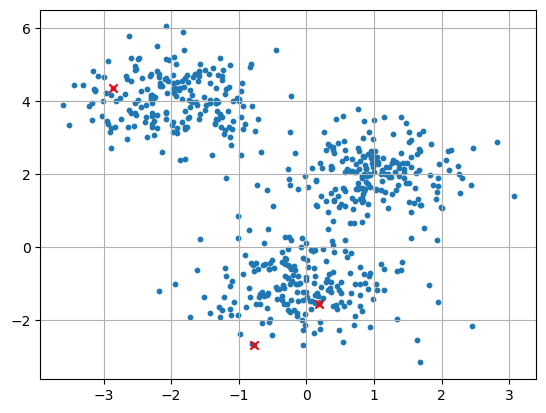

In [15]:
# generate data
X = ex3_generate_data()

# initialize means
means = initialize_means(X, 3)

# plot data
plt.figure()
plt.scatter(X[:,0], X[:,1], 10)
plt.scatter(means[:,0], means[:,1], c="red", marker="x")
plt.grid()

### End of exercise 3.1
---
---

Now that the clusters have been initialized, it is time to assign points to the closest clusters.

---
---
### Exercise 3.2: Assign points to clusters
Again consider the function `X = ex4_generate_data()` which generates a matrix ${\bf{X}}$ of shape (N x D), representing the vertical concatenation of $N$ transposed data vectors of dimension $D$. Create a function `rho = assign_data_to_clusters(X, means)` that accepts the data set ${\bf{X}}$ and matrix of means ${\bf{\mu}}$ as input and returns a matrix of shape (N x K), which contains all indicator functions $\rho_k^{(n)}$. This matrix should be a matrix of only ones and zeros and each row should sum to 1.

In [16]:
#// BEGIN_TODO [5ARB0_Analysis_3_2] Complete the function assign_data_to_clusters(X, means)

def assign_data_to_clusters(X, means):
    # get the dimensions
    N, D = X.shape
    
    # get the size of the first dimension ie. len(means)
    K = means.shape[0]  # K is set to the number of rows (cluster centroids) in the means array.
    
    # initialize a Zero matrix to represent the assignment of data points to clusters
    rho = np.zeros((N, K))  # Each row in this array corresponds to a data point, and each column corresponds to a cluster. (1 = a data point belongs to a particular cluster)
    
    for i in range(N): # for all data points in X
        
        # calculate the Euclidean distance between the current data point (X[i]) and all cluster centroids (means) 
        q = np.linalg.norm(X[i]-means, axis=1) # axis = 1 calculates the norm for each row separately, measuring the distance between X[i] and each cluster centroid individually.
        
        # find the index of the cluster with the smallest distance and assign the data point to that cluster (rho = 1)
        rho[i, np.argmin(q, axis=0)] = 1 #  axis=0 => minimum should be computed along the first axis

    return rho 
    

#// END_TODO [5ARB0_Analysis_3_2]

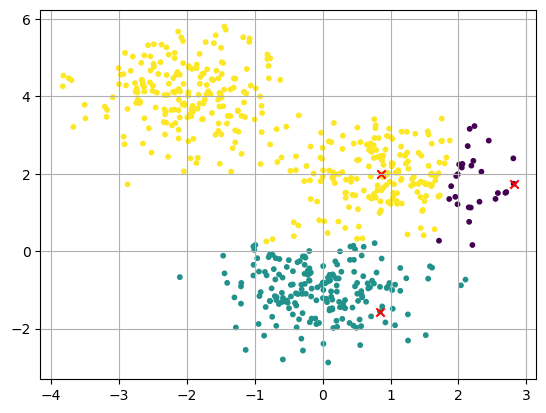

In [17]:
# generate data
X = ex3_generate_data()

# initialize means
means = initialize_means(X, 3)

# assign point to clusters
rho = assign_data_to_clusters(X, means)

# plot data
plt.figure()
plt.scatter(X[:,0], X[:,1], 10, c=np.argmax(rho, axis=1))
plt.scatter(means[:,0], means[:,1], c="red", marker="x")
plt.grid()

### End of exercise 3.2
---
---

The means have been initialized, the point have been assigned to a cluster. Now the cluster centers can be updated.

---
---
### Exercise 3.3: Update cluster centers

Again consider the function `X = ex3_generate_data()` which generates a matrix ${\bf{X}}$ of shape (N x D), representing the vertical concatenation of $N$ data vectors of dimension $D$. Create a function `means = update_cluster_centers(X, rho)` that accepts the data set ${\bf{X}}$ and matrix of indicators $\rho$ as input and returns a matrix of shape (K x D), which contains the new cluster centers.

In [18]:
#// BEGIN_TODO [5ARB0_Analysis_3_3] Complete the function update_cluster_centers(X, rho)

def update_cluster_centers(X, rho):
    """
    Update the cluster mean to be the mean location of the points assigned to that cluster.
    
    Parameters:
    N: Number of datapoints
    K: Number of clusters
    D: Length of the datapoints
    X (np.ndarray): Dataset of all Data points (N x D).
    rho (np.ndarray): Cluster assignments (N x K).
    
    Returns: 
    mean_update (np.ndarray): Updated cluster centroids (K x D).
    """
    
    #initialize prameters 
    N, D = X.shape
    K = rho.shape [1]
    
    # Initialize the new means with all entries being zero (cluster_number_K, features_D)
    mean_update = np.zeros ((K, D))
    
    # Initialize the cluster matrix that contains the cluster information for all data points (600,)
    cluster = np.argmax(rho, axis=1)
    
    # For every cluter (K)
    for i in range (K):
        
        # Initialize a temporary cluster matrix to assign the data points
        temp_cluster = []
        
        # For every data point (N)
        for j in range(N):
            
            # Check if the data point is assigned to the current cluster
            if cluster[j] == i:
                
                # If so, include that data point
                temp_cluster.append(X[j])

        # Calculate the new mean of the cluster from the included data points
        temp_mean = np.mean(temp_cluster, axis=0)
        
        # Assign the calculated mean to the corresponding cluster
        mean_update[i] = temp_mean
        
    return mean_update
#// END_TODO [5ARB0_Analysis_3_3]

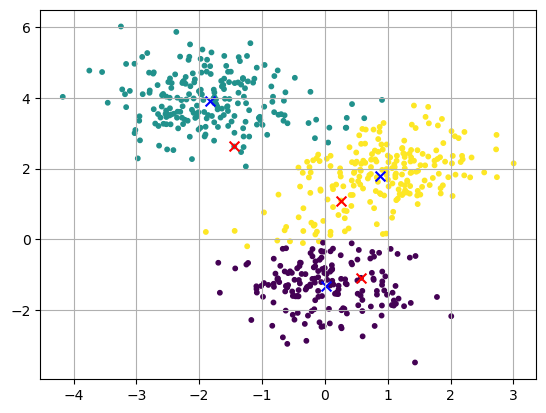

In [19]:
# generate data
X = ex3_generate_data()

# initialize means
means = initialize_means(X, 3)

# assign point to clusters
rho = assign_data_to_clusters(X, means)

# update means
means_new = update_cluster_centers(X, rho)

# plot data
plt.figure()
plt.scatter(X[:,0], X[:,1], 10, c=np.argmax(rho, axis=1))
plt.scatter(means[:,0], means[:,1], 50, c="red", marker="x")
plt.scatter(means_new[:,0], means_new[:,1], 50, c="blue", marker="x")
plt.grid()

### End of exercise 3.3
---
---

Almost there! Now it is just a matter of combining the previous functions for finalizing the K-means algorithms.

---
---
### Exercise 3.4: Implement K-means algorithm

First create a function `J = Kmeans_loss(X, means, rho)` that calculates the within-cluster Euclidean squared distance as defined above. Secondly create the final `means, rho, J = Kmeans(X, K)` function that combines all previous functions to create the K-means algorithm as specified in the the introduction of this part of the assignment. This function returns the final cluster centers, the indicator function and a history of the losses. Save the loss *after* each iteration and stop iterating when the difference in loss does no longer exceed 1e-10. The initial loss based on the randomly initialized means should not be returned.

In [20]:
#// BEGIN_TODO [5ARB0_Analysis_3_4a] Complete the Kmeans_loss(X, means, rho) function

def Kmeans_loss(X, means, rho):
    """
    Calculates the within-cluster Euclidean squared distance between cluster centers and datapoints

    Parameters
    -----------------
    X     (np.ndarray)  : Data points (N x D).
    means (np.ndarray)  : Cluster centroids (K x D).
    rho   (np.ndarray)  : Cluster assignments (N x K).
                          All of its elements are either 0 or 1. Each row summs to 1.

    Returns
    -----------------
    loss     (float)     : The average sum of within-cluster Euclidean squared distance. Euclidean Squared Distance=∑(A -B)**2
    """
    
    # Initialize prameters 
    N, D = X.shape
    K = rho.shape [1]

    # Initialize the cluster matrix that contains the cluster information for all data points, vector of shape (600,)
    cluster = np.argmax(rho, axis=1)
    
    distance = 0.0
    
    # For every cluster (K)
    for i in range (K): 
        
        # Get the datapoints assigned to each cluster, instead of an if-statement to check if the point is in the cluster
        cluster_points = X[rho[:,i] == 1]

        # calculate within-cluster Euclidean squared distance resulting from cluster_points - mean 
        euclidean_distances = np.linalg.norm((cluster_points - means[i])**2)   
        distance += euclidean_distances
    
    # Calculating average distance 
    loss = distance/N    
    
    return loss
    

#// END_TODO [5ARB0_Analysis_3_4a]

In [21]:
#// BEGIN_TODO [5ARB0_Analysis_3_4b] Complete the Kmeans(X, K) function

def Kmeans(X, K):
    """
    Desc
    ---------------
    The K-means Algorithm iterates through the k-means clustering steps until a certian convergence limit is
    reached or a certian number of iterations are exceeded.
    
    Parameters
    ---------------
    X     (np.ndarray) : The Dataset shape of (N, D)
    K     (int)        : Number of Clusters
    
    Return
    ---------------
    means (np.ndarray) : Current Cluster Means shape of (K, D) where K is the number of clusters
    rho   (np.ndarray) : Indicator Function of Data Points. Has a shape of (N, K) where K is the total number of clusters. 
                         All of its elements are either 0 or 1. Each row summs to 1.
    J     (float)      : The averaged sum of sqaured distances of each data point to its assigned cluster
    """
    
    # Initialize cluster centroids
    means = initialize_means(X,K)
    
    # Create empty list to store the loss in each step to calculate the convergence
    loss_history = []
    
    # Initialize the number of iterations
    iterations = 0

    while True: 
        # Assign data points to clusters
        rho = assign_data_to_clusters(X,means)
        
        # Update cluster centroids
        means = update_cluster_centers(X,rho)
        
        # Calculate loss and append it to the history 
        loss_history.append(Kmeans_loss(X, means, rho))
        
        # Check for convergence (stop when the loss change is small) or max iterations
        if iterations > 1: # skip the first iteration 
            if (np.diff(loss_history[-2:]) < 1e-10 or iterations > 2000):
                break
        else: 
            iterations += 1
    
    return means, rho, loss_history

#// END_TODO [5ARB0_Analysis_3_4b]

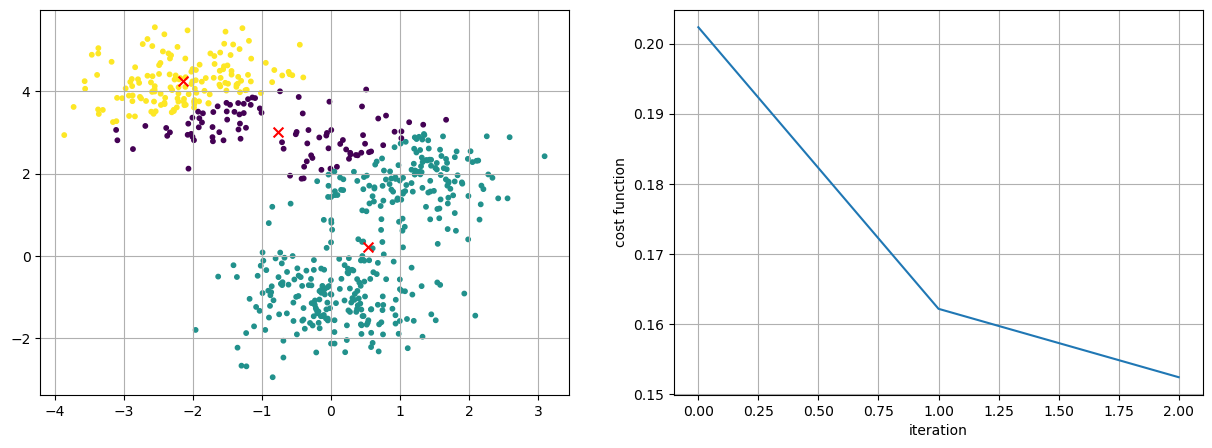

In [22]:
# generate data
X = ex3_generate_data()

# initialize means
means, rho, J = Kmeans(X, 3)

# plot data
_,ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].scatter(X[:,0], X[:,1], 10, c=np.argmax(rho, axis=1))
ax[0].scatter(means[:,0], means[:,1], 50, c="red", marker="x")
ax[1].plot(J)
ax[0].grid(), ax[1].grid(), ax[1].set_ylabel("cost function"), ax[1].set_xlabel("iteration");

### End of exercise 3.4
---
---

---
---
### Exercise 3.5: Number of clusters
In the previous assignment the data had been generate from 3 clusters. In practice the number of clusters is often unknown. In this exercise we will see what happens when we add extra clusters. In this exercise, run your K-means algorithm on the previous data set for 2 up to and including 10 clusters and save the final value of the loss (i.e. the loss value when the algorithm has converged).

Plot the final loss against the number of used clusters.

In [23]:
# generate data
X = ex3_generate_data()

<function matplotlib.pyplot.show(close=None, block=None)>

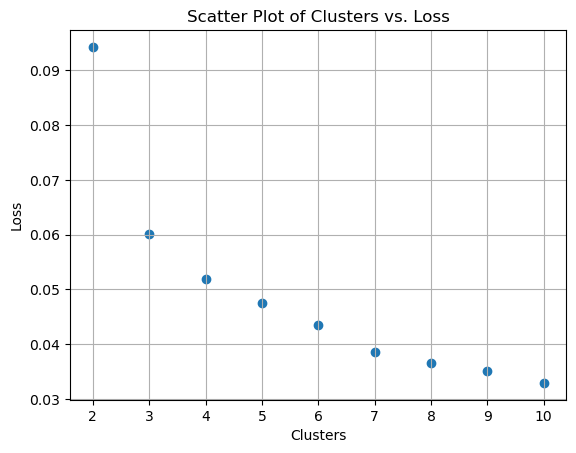

In [40]:
#// BEGIN_TODO [5ARB0_Analysis_3_5a] Plot the Kmeans loss against the number of clusters


# Initialize the set that includes cluster numbers
clusters = [i for i in range(2,11)]

# Initialize empty set to store the loss function
loss = []

# Calculate the final loss function for different number of clusters (K=10 down to(-1) K=10)
for K in clusters:
    loss.append(Kmeans(X, K)[2][-1:])
    
# Plot the final loss against the number of used clusters
plt.figure()
plt.scatter(clusters, loss)

# Adding labels and title (optional)
plt.xlabel("Clusters")
plt.ylabel("Loss")
plt.title("Scatter Plot of Clusters vs. Loss")

# Display the plot
plt.grid()
plt.show 


#// END_TODO [5ARB0_Analysis_3_5a]

Does the loss give a good impression of how many clusters can be found in the data set?

1. Yes, the loss tells us how good the data is represented. As the loss decreases, the model becomes better at representing the data. Therefore the final loss provides a good indication how many clusters are desirable.
2. Yes, if we have a very large number of clusters, the loss can be brought to zero, leading to a perfect representation of the data.
3. No, the loss function only decreases and does not take into account the complexity introduced by adding more clusters.
4. All of the above answers are correct.
5. None of the above answers are correct

Answer this question by assigning the number corresponding to your answer to the variable `answer` (for example `answer = 6`) in the code cell below.

In [25]:
#// BEGIN_TODO [5ARB0_Analysis_3_5b] Finding an appropriate number of clusters

asnwer = 3

#// END_TODO [5ARB0_Analysis_3_5b]

How can we find an appropriate number of clusters for representing some data set?

1. We select the number of clusters where the loss function begins to increase.
2. We can monitor the loss function and select the number of clusters for which it obtains its lowest value. The corresponding number of clusters is an appropriate number of clusters.
3. We could add a penalty term for the number of clusters to the cost and then select the lowest value.
4. All of the above answers are correct.
5. None of the above answers are correct

Answer this question by assigning the number corresponding to your answer to the variable `answer` (for example `answer = 6`) in the code cell below.

In [26]:
#// BEGIN_TODO [5ARB0_Analysis_3_5c] how can we find the number of clusters

answer = 2

#// END_TODO [5ARB0_Analysis_3_5c]

### End of exercise 3.5
---
---

---
---
### Exercise 3.6: Shortcoming of the K-means algorithm
Apply the Kmeans algorithm for the new data set generate by `X = ex36_generate_data()`. Visualise the data and come up with an appropriate number of clusters. Plot the data points in a scatter plot, plot the means as red crosses in the same plot and color the data point according to their assigned cluster.

In [41]:
# generate data
X = ex36_generate_data()

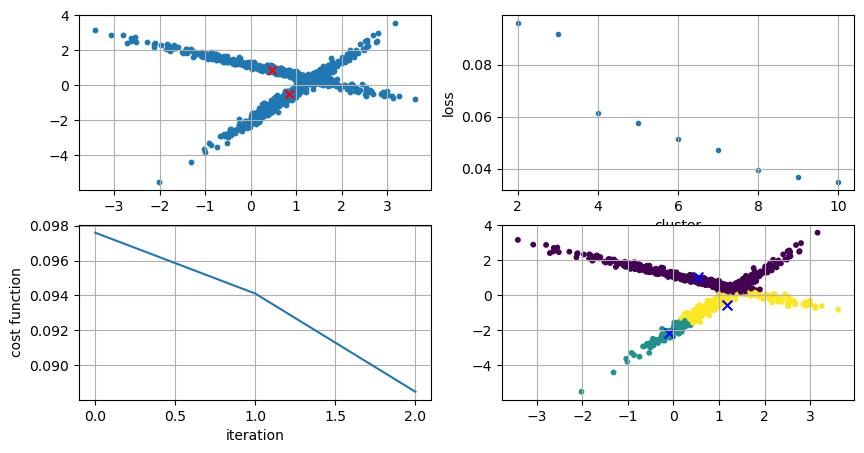

In [42]:
#// BEGIN_TODO [5ARB0_Analysis_3_6a] Plot clusters of new data set


# Calculate the loss for different number of clusters
clusters = [i for i in range(2,11)]
loss = []
for K in clusters:
    loss.append(Kmeans(X, K)[2][-1:])
    
# Plot the data and the loss function with different numbers of clusters
# creating 4 subplots 
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))

# top- left corner: dataset and means 
ax[0,0].scatter(X[:,0], X[:,1], 10)
ax[0,0].scatter(means[:,0], means[:,1], c="red", marker="x")

# top- right corner: cluster against loss
ax[0,1].scatter(clusters, loss, 9)
ax[0,0].grid(), ax[0,1].grid(), ax[0,1].set_xlabel("cluster"), ax[0,1].set_ylabel("loss");

# Perform K-means Clustering
means, rho, J = Kmeans(X, 3)

# Plot the Loss function wrt number of iterations and clustered data including cluster centers
ax[1,0].plot(J)
ax[1,1].scatter(X[:,0], X[:,1], 10, c=np.argmax(rho, axis=1)) # c=np.argmax(rho, axis=1) colors data points based on the cluster they're assigned to (indicated by rho)
ax[1,1].scatter(means[:,0], means[:,1], 50, c="blue", marker="x")
ax[1,0].grid(), ax[1,1].grid(), ax[1,0].set_ylabel("cost function"), ax[1,0].set_xlabel("iteration");


#// END_TODO [5ARB0_Analysis_3_6a]

### End of exercise 3.6
---
---

## Part 4: Gaussian Mixture modeling
The Kmeans algorithm is a very fast and simple algorithm that works well for many applications. However, because of its simplicity it is not suitable for all situations, such as the one described in exercise 1.6. In this part we present another methodology for clustering data, namely through Gaussian mixture modeling. In this approach we do not rely on a deterministic algorithm for determining the cluster means and assignments, but instead we model the data set by a probability density function.

We will assume that the data set has been generated from a Gaussian mixture model, which is formally specified as
$$ p({\bf{x}}^{(n)}) = \sum_{k=1}^K \rho_k \mathcal{N}({\bf{x}}^{(n)} \mid {\bf{\mu}}_k, \Sigma_k),$$
where a data sample ${\bf{x}}^{(n)}$ is originating from a Gaussian mixture model with $K$ individual Gaussian distributions with means ${\bf{\mu}}_k$ and covariance matrices ${\bf{\Sigma}}_k$. The mean denotes the center or mode of the Gaussian distribution and the covariance matrix specifies the strech and tilt of the Gaussian distribution. In this model the mixing coefficients $\rho_k$ specify how much each of the Gaussian distributions contributes in the model. Because the Gaussian mixture model is a probability density function, integrating over ${\bf{x}}$ should always equal 1. Because the individual Gaussians already satisfy this requirement, the mixing coefficients are constrained by
$$ \sum_{k=1}^K \rho_k = 1.$$
To give some intuition on this model, we give a 1-dimensional example below. Here we model a data set by a mixture of 2 Gaussians. The individual *weighted* Gaussian distributions are colored in blue and the corresponding mixture model distribution is colored in red.

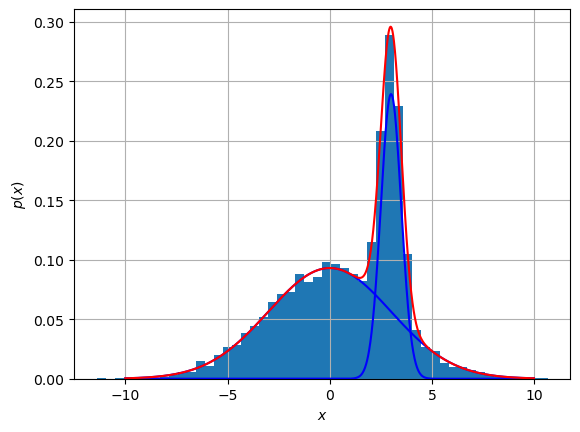

In [29]:
ex4_plot_GMM_1D()

During this part of the assignment you will implement the so-called Expectation-Maximization (EM) algorithm for learning the Gaussian mixture model. This algorithm consists of two step, the expectation step (E-step) and the maximization step (M-step). The exact details of the algorithm are beyond the scope of this assignment, but here we will present the update equations for these steps.

The EM algorithm works as follows:

1. Initialize the means ${\bf{\mu}}_k$, covariances $\Sigma_k$ and mixing coefficients $\rho_k$. Often the means are initialized using the Kmeans algorithm. The covariance matrices can be set to identity matrices and the mixing coefficients can be initialized to the fraction of points assigned to the cluster with Kmeans divided by the total number of samples.
2. *Expectation step*: evaluate the responsibilities $\gamma_{nk}$ using the current parameter values as 
$$ \gamma_{nk} = \frac{\rho_k \mathcal{N}({\bf{x}}_n \mid {\bf{\mu}}_k, \Sigma_k)}{\sum_{j=1}^K \rho_j \mathcal{N}({\bf{x}}_n \mid {\bf{\mu}}_j, \Sigma_j)}$$
3. *Maximization step*: re-estimate the parameters using the current responsibilities
$$ {\bf{\mu}}_k^\text{new} = \frac{1}{N_k} \sum_{n=1}^N \gamma_{nk}{\bf{x}}_n $$
$$ \Sigma_k^\text{new} = \frac{1}{N_k} \sum_{n=1}^N \gamma_{nk} ({\bf{x}}_n - {\bf{\mu}}_k^\text{new})({\bf{x}}_n - {\bf{\mu}}_k^\text{new})^\top $$
$$ \rho_k = \frac{N_k}{N} $$
where $N$ denotes the number of samples and where
$$ N_k = \sum_{n=1}^N \gamma_{nk}$$
4. Evaluate the log-likelihood
$$ \ln p({\bf{X}} \mid {\bf{\mu}}, \Sigma, {\bf{\rho}}) = \sum_{n=1}^N \ln \left\{ \sum_{k=1}^K \rho_k \mathcal{N}({\bf{x}}^{(n)} \mid {\bf{\mu}}_k, \Sigma_k)\right\}$$

It is important to grasp what is going on in this algorithm. The responsibilities $\gamma_{nk}$ are similar to the indicator functions from the Kmeans algorithm. However, where the Kmeans algorithm performs a hard clustering (each point can be assigned to only 1 cluster), the Gaussian mixture model allows for a soft clustering (each point can be modeled by both Gaussian distribution, but just to a different extent). The indicator function of the Kmeans algorithm was one-hot coded, meaning that a point was assigned to 1 cluster only. The responsibilities $\gamma_{nk}$ specify how likely a data sample ${\bf{x}}_n$ is to be generated from a cluster. With a Gaussian mixture model a point can therefore be assigned to different extents to multiple clusters. The expectation step calculates these responsibilities and the division in this expression makes sure that all rows sum op to 1.

In the maximization step the parameters are updated. Here the contribution of each data sample towards the parameters depends on the corresponding responsibilities. This means that a point that is very likely to have originated from a certain cluster will have a high influence on the statistics of that cluster. The variable $N_k$ specifies how many points are located to a certain Gaussian distribution. Because this parameter is the summation over the individual responsibilities, $N_k$ is not forced to be an integer.

The log-likelihood is a cost function which takes the variances and uncertainties in our model into account. It describes the probability of that data set being generated from a Gaussian mixture model. To prevent numerical instability we commonly use the log-likelihood instead of the normal likelihood.


---
---
### Exercise 4.1: Initialize clusters
Consider the function from the previous part `X = ex46_generate_data()` which generates a matrix ${\bf{X}}$ of shape (N x D), representing the vertical concatenation of $N$ transposed data vectors of dimension $D$. Create a function `means, covs, rho = initialize_GMM(X, K)` that accepts the data set ${\bf{X}}$ as input and returns the following in this order:
- `means`: a matrix of size (K x D) that contains the initial cluster means, as a vertical concatenation of the transposed mean vectors. These means should be initialized using the previously written K-means algorithm.
- `covs`: a matrix of size (K x D x D) that contains the covariance matrices of the initial clusters. Each matrix `covs[k,:,:]` represents the covariance matrix of the $k^\text{th}$ cluster. Initialize these covariance matrices as identity matrices.
- `rho`: a vector of length K that contains the mixing coefficients as specified above. Initialize this vector based on the indicator function returned by the K-means algorithm.

In [30]:
#// BEGIN_TODO [5ARB0_Analysis_4_1] Complete the initialize_GMM(X, K) function

def initialize_GMM(X, K):
    """
    Initiliazes the data relevant for the GMM. 
    
    Parameters
    ----------
      X   np.ndarray(N x D)     : represents dataset 
      K   integer               : Number of clusters 
      
    Returns
    -------
    means np.ndarray(K x D)     : contains the initial cluster means, as a vertical concatenation of the transposed mean vectors.
    covs  np.ndarray(K x D x D) : contains the covariance matrices of the initial clusters.
    rho   np.ndarray(K)         : contains the mixing coefficients (shows the soft probility that a point belongs to a cluster)
    """
    
    # Initialize X 
    N, D = X.shape
    
    # Initialize means 
    means = initialize_means(X,K)
    
    # Initialize covariance matrices as identity matrices.
    covs = np.zeros((K, D, D)) # A DxD matrix for each cluster (K)
    
    # Initialize a covariance matrix For each cluster
    for k in range(K): 
        covs[k] = np.identity(D)
    
    # Initialize mixing coefficients  
    rho = np.zeros (K)
    
    # Iterate over the clusters to find the posibility of initial cluster assignments
    for k in range(K):
        rho[k] = np.sum(assign_data_to_clusters(X,means)[:,k] == 1) / N    
    
    return means, covs, rho
    

#// END_TODO [5ARB0_Analysis_4_1]

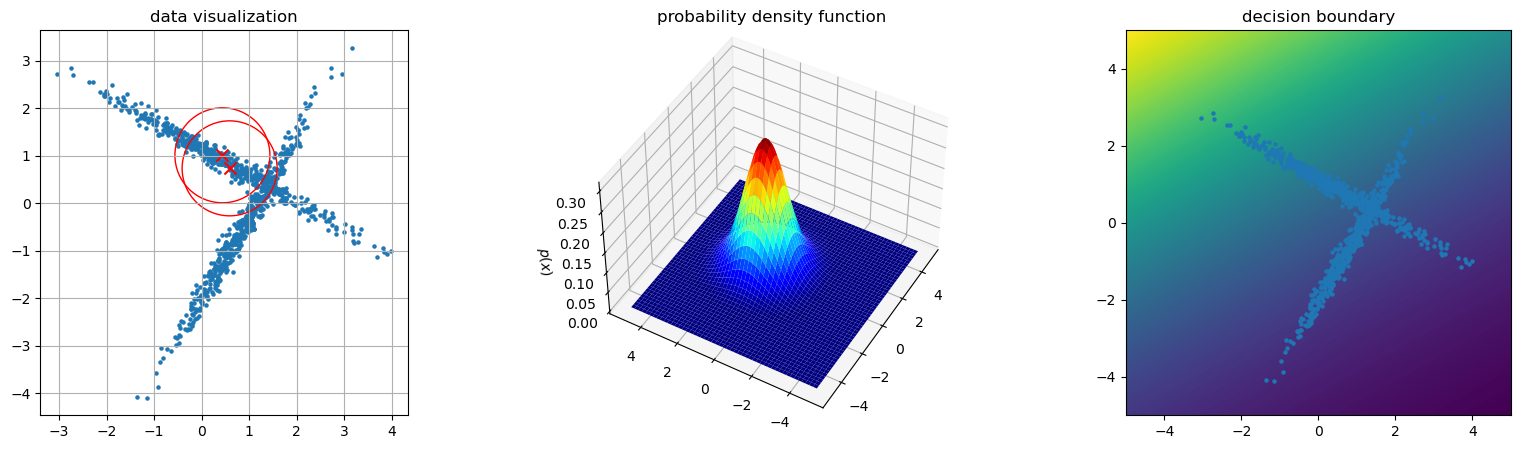

In [31]:
# fetch data
X = ex36_generate_data()

# initialize GMM
means, covs, rho = initialize_GMM(X, 2)

# plot GMM
ex4_plot_GMM(X, means, covs, rho)

### End of exercise 4.1
---
---

---
---
### Exercise 4.2: Expectation step
Create a function `gamma = expectation_step(X, means, covs, rho)` that accepts the data set, means, covariances and mixing coefficients with dimensions specified above. This function should perform the expectation step and should return the calculated responsibilities as defined above as a matrix of size (N x K) where each row corresponds to the assignment fraction of a sample amongst the different clusters. Make sure this matrix is properly normalized such that the elements in each row add up to 1. Use the `multivariate_normal` function that has been imported from `scipy.stats` at the beginning of this notebook.

In [32]:
#// BEGIN_TODO [5ARB0_Analysis_4_2] Complete the expectation_step(X, means, covs, rho) function

def expectation_step(X, means, covs, rho):
    """
    Perform the expectations step and returns the calculated responsibilities as a matrix of size (N x K) 
    where each row corresponds to the assignment fraction of a sample amongst the different clusters. 
    
    Parameters
    ----------
    X     np.ndarray(N x D)     : represents the vertical concatenation of  𝑁 transposed data vectors of dimension D. 
    means np.ndarray(_ x D)     : contains the initial cluster means, as a vertical concatenation of the transposed mean vectors.   
      
    Returns
    -------
    gamma np.ndarray(N x K)     : contains calculated responsibilities - how likely it is for a point to belong to a cluster 
    """
    # Initialize parameters
    N,D = X.shape
    _,K = means.shape
    gamma = np.zeros((N, K))
    
    # Iterate over each datapoint
    for n in range(N):
        
        # Iterate over each cluster
        for k in range(K):
            
            # Calculate the likelihood of the node (N) belonging to the cluster (K)
            likelihood_n_belong_to_k = multivariate_normal.pdf(X[n], mean=means[k], cov=covs[k])
            
            # Multiply likelihood with the mixing coefficients 
            gamma[n, k] = rho[k] * likelihood_n_belong_to_k
        
        # Normalize the values    
        gamma[n] /= np.sum(gamma[n])
     
    return gamma

#// END_TODO [5ARB0_Analysis_4_2]

In [33]:
gamma = expectation_step(X, means, covs, rho)

### End of exercise 4.2
---
---

---
---
### Exercise 4.3: Maximization step
Create a function `means, covs, rho = maximization_step(X, gamma)` that accepts the data set and responsibilities with dimensions specified above. This function should perform the maximization step and should return the new means, covariances and mixing coefficients with dimensions as specified above.

In [34]:
#// BEGIN_TODO [5ARB0_Analysis_4_3] Complete the maximization_step(X, gamma) function

def maximization_step(X, gamma):
    """
    Performs the maximization step and returns the new means, covariances and mixing coefficients
    
    Parameters
    ----------
    X         np.ndarray(N x D)     : represents the vertical concatenation of 𝑁 transposed data vectors of dimension D. 
    K         integer               : Number of clusters 
    
    Returns 
    -------
    new_means np.ndarray(K x D)     : contains the maximized cluster means, as a vertical concatenation of the transposed mean vectors.
    new_covs  np.ndarray(K x D x D) : contains the covariance matrices of the new clusters.
    new_rho   np.ndarray(K)         : contains the new mixing coefficients   
    """
    # Initialize X 
    N, D = X.shape
    
    # Get new K, number of clusters 
    K = gamma.shape[1]
    
    # Initialize new_means, new_cov, new rho 
    new_means = np.zeros((K, D))
    new_covs = np.zeros((K, D, D))
    new_rho = np.zeros(K)
    
    # Iterate over each cluster (each cluster has different gamma and therefore different calculation)
    for k in range(K): 
        # Calculate the summed gamma used in all calculations (= Nk)
        gamma_sum = np.sum(gamma[:, k])
        
        # Calculate expected mean
        new_means[k] = np.dot(gamma[:, k], X) / gamma_sum
        cov_matrix = np.zeros((D,D))
        
        # For all data points: 
        for n in range(N): 
            dis = X[n] - new_means[k]
            covs = np.zeros((D,D))
            for i in range(D): # all rows
                for j in range(D): # all columns
                    covs[i,j] = dis[i]* dis[j] 
            cov_matrix += gamma[n,k] * covs
            
        new_covs[k] = cov_matrix / gamma_sum
        
        # calculate expected rho 
        new_rho[k] = gamma_sum / N
    return new_means,new_covs,new_rho

#// END_TODO [5ARB0_Analysis_4_3]

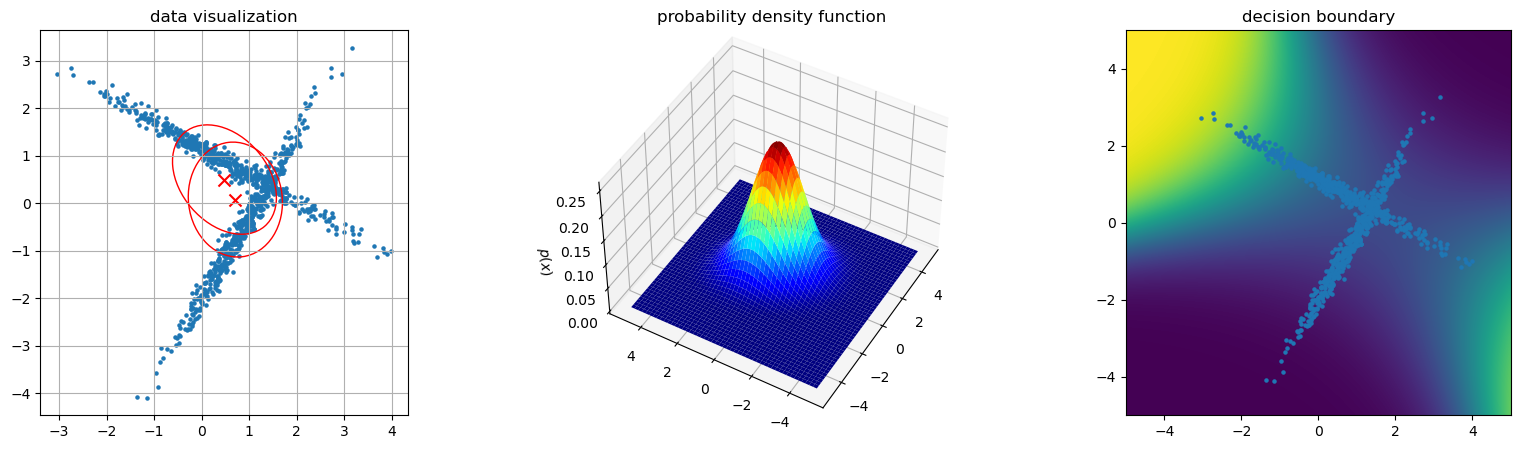

In [35]:
# maximization step
means, covs, rho = maximization_step(X, gamma)

# plot GMM
ex4_plot_GMM(X, means, covs, rho)

### End of exercise 4.3
---
---

---
---
### Exercise 4.4: Log-likelihood calculation
Create a function `J = loglikelihood(X, means, covs, rho)` that accepts the data set, means, covariance matrices and mixing coefficients with dimensions specified above. This function should calculate and return the log-likelihood of the data under the specified Gaussian mixture model. Use the definition as specified in the beginning of Part 2.

In [36]:
#// BEGIN_TODO [5ARB0_Analysis_4_4] Complete the loglikelihood(X, means, covs, rho) function

def loglikelihood(X, means, covs, rho):
    """
    Calculates and returns the log-likelihood of the data under the specified Gaussian mixture model (GMM)
    
    Parameters
    ----------
    X     np.ndarray(N x D)     : Data set
    means np.ndarray(_ x D)     : Contains the maximized cluster means  
    covs  np.ndarray(K x D x D) : Contains the covariance matrices of the maximized clusters. K D x D matrices 
    rho   np.ndarray(K)         : Contains the maximized mixing coefficients for each cluster
      
    Returns
    -------
    J     np.ndarray(N)         : Array of log-likelihood values for each data point
    """
    
    # Initialize X (Data Set) and K (numerb of clusters) 
    N, D = X.shape
    K = len(rho)
    
    # Initialize J (log_likelihood)
    J = np.zeros(N)
    
    # For all data points in the data set (N)
    for n in range(N):
        likelihood_n = 0.0
        
        # For all cluster 
        for k in range(K):
            
            # Likelihood of data point X[n] belonging to cluster k
            likelihood_n += rho[k] * multivariate_normal.pdf(X[n], mean=means[k], cov=covs[k])
            
        # logarithm of the likelihood for each data point 
        J[n] += np.log(likelihood_n)
    
    return J  

#// END_TODO [5ARB0_Analysis_4_4]

### End of exercise 4.4
---
---

---
---
### Exercise 4.5: Gaussian mixture modeling
Now that all the subfunctions have been defined it is time to tie them together and to form a function which does the Gaussian mixture modelling. Create a function `means, covs, rho, gamma, J = GMM_modeling(X, K, nr_iterations)` that does the following:

1. Initialize the parameters of the Gaussian mixture model.
2. Performs `nr_iterations` iterations of the following:
    1. Perform the expectation step.
    2. Perform the maximization step.
    3. Calculate the log-likelihood.
3. returns the parameters and a vector of saved values of the log-likelihood.

The function should return all the parameters of the trained Gaussian mixture model, containing the final means, covariance matrices, mixing coefficients, responsibilities and a vector containing all calculated values of the log-likelihood.

In [37]:
#// BEGIN_TODO [5ARB0_Analysis_4_5] Complete the GMM_modeling(X, K, nr_iterations) function

def GMM_modeling(X, K, nr_iterations):
    """
    Caluate and return all the parameters of the trained Gaussian mixture model, containing the final means, covariance matrices,
    mixing coefficients, responsibilities and a vector containing all calculated values of the log-likelihood.
    
    Steps
    -----
   1. Initialize the parameters of the Gaussian mixture model.
   2. Performs nr_iterations iterations of the following:
       A. Perform the expectation step.
       B. Perform the maximization step.
       C. Calculate the log-likelihood.
   3. Returns the parameters and a vector of saved values of the log-likelihood.
    
    Parameters
    ----------
    
    X     np.ndarray(N x D)     : Represents the vertical concatenation of 𝑁 transposed data vectors of dimension D. 
    K     integer               : Number of clusters 
    
    Returns 
    -------
    means np.ndarray(K x D)                 : Contains cluster means
    covs  np.ndarray(K x D x D)             : Contains covariance matrices of clusters
    rho   np.ndarray(K)                     : Contains mixing coefficients  
    gamma np.ndarray(N x K)                 : Contains calculated responsibilities
    J     np.ndarray(nr_iterations)         : Contains all calculated values of the log-likelihood
    """
    # Initialize GMM
    means, covs, rho = initialize_GMM(X, K)
    
    # Initialize J as a vector for calculated values of the log-likelihood                  
    J = np.zeros(nr_iterations)
    
    for i in range (nr_iterations):
        
        # A. Expectation step
        gamma = expectation_step(X, means, covs, rho)
        
        # B. Maximization step
        means, covs, rho = maximization_step(X, gamma)
        
        # C. Calculate the log-likelihood
        J [i] = np.sum(loglikelihood(X, means, covs, rho))
            
    return means, covs, rho, gamma, J
    
#// END_TODO [5ARB0_Analysis_4_5]

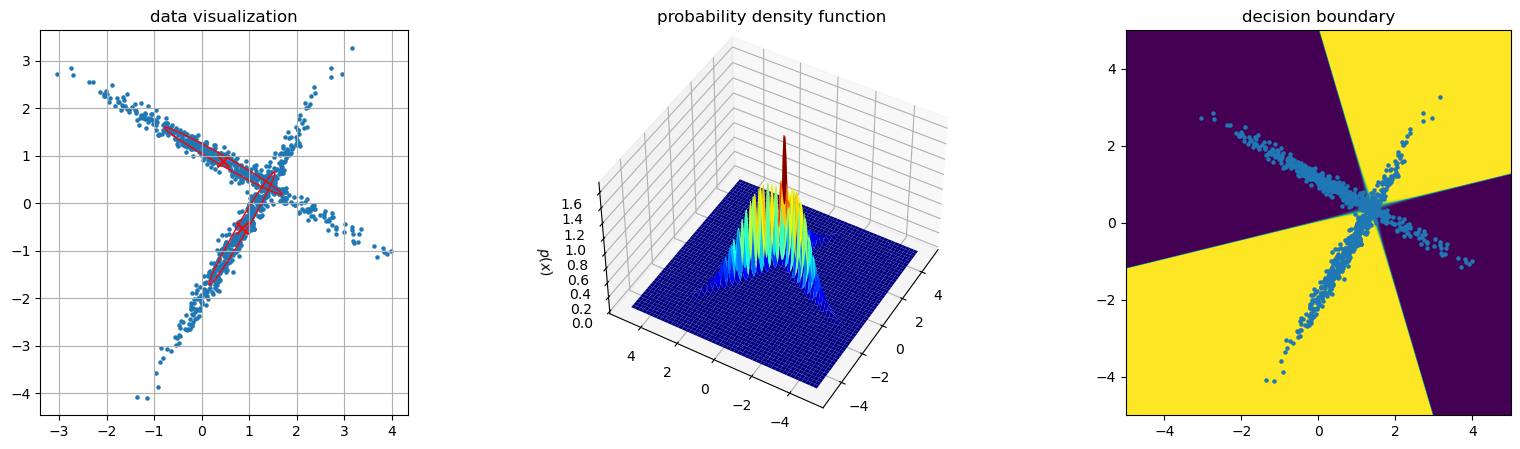

In [38]:
# train GMM
means, covs, rho, gamma, J = GMM_modeling(X, 2, 10)

# plot GMM
ex4_plot_GMM(X, means, covs, rho)

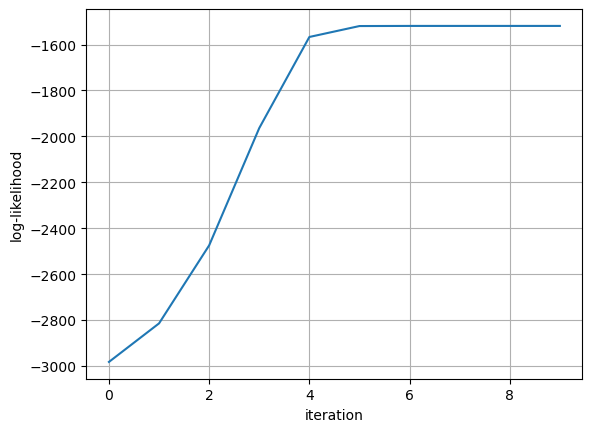

In [39]:
plt.figure()
plt.plot(J)
plt.grid(), plt.xlabel("iteration"), plt.ylabel("log-likelihood");

### End of exercise 4.5
---
---

>   Make sure to restart this notebook and to rerun all cells before submission to check whether all code runs properly.